# Full Pipeline (Visual Entailment)

## 1. Load Data
- Read JSONL file (Image_ID, Hypothesis, Label).
- Map `Image_ID → image_path` from images folder.
- Keep only `{image_path, Hypothesis, Label}`.

## 2. Exploratory Data Analysis (EDA)
- Plot label distribution (entailment vs contradiction).
- Show hypothesis length histogram.
- Display sample image + hypothesis pairs.

## 3. Data Splitting
- Stratified split into train / val / test sets.
- Fix random seed for reproducibility.
- Compute class weights if labels are imbalanced.

## 4. Preprocessing
- **Image**: decode → resize (224×224) → normalize → augment (flip, rotate, contrast).
- **Text**: `TextVectorization` (fit on train only) → pad/truncate to max_len.

## 5. Baseline Models
- **Image-only**: EfficientNetB0 + GAP + Dense.
- **Text-only**: Embedding + BiLSTM + Dense.
- **Concat fusion**: [EffNet features + BiLSTM features] → Concat → Dense.

## 6. Advanced Model (Final Design)
- **Image branch**: EfficientNetB0 pretrained backbone (fine-tuned top layers).
- **Text branch**: Embedding + BiLSTM.
- **Fusion**: Cross-Attention + FiLM.
- **Output**: Dense head → sigmoid (binary classification).

## 7. Training
- Loss: Binary cross-entropy.
- Optimizer: Adam.
- Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint.
- Train with class weights if needed.

## 8. Evaluation
- Metrics: Macro-F1 (primary), Accuracy, Precision/Recall.
- Plots: learning curves, confusion matrix, ROC/PR curves.
- Slice analysis (by text length, brightness, subject keywords).

## 9. Ablation Studies
- Compare:
  - Image-only
  - Text-only
  - Concat fusion
  - Cross-Attention only
  - FiLM only
  - Cross-Attention + FiLM (final)
- Report Macro-F1 and Accuracy for each.

## 10. Independent Stress Test (HD+)
- Create ~100 custom examples (negation, entity swap, counts, spatial prepositions).
- Evaluate final model.
- Analyze common failure modes.

## 11. Ultimate Judgment
- Select the best model.
- Justify based on performance, robustness, and inference cost.
- State limitations and possible future improvements.

## 12. Future Predictions
- Run final model on unseen future set.
- Save results as `predictions.csv`.

## 13. Demo Video
- Explain the entire pipeline (≤ 15 min).
- Cover: Problem → Data → Baselines → Advanced model → Training → Results → Ablations → Stress test → Ultimate judgment → How to run on AWS.


In [2]:
# pip install -U "tensorflow[and-cuda]==2.19.1" "keras==3.6.0" "ml-dtypes==0.5.1" "tensorflow-text==2.19.0" keras-hub --only-binary=:all:


In [4]:
# === 0. Imports, config, seeds ===
import os, json, glob, random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [6]:
# Automatically tunes performance for data pipelines in TensorFlow
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set style and context for larger labels and a cleaner look
sns.set(style="whitegrid")

# Define a color palette
palette = sns.color_palette("Blues_d")

In [7]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths (edit these)
DATA_FILE = "A2_train_v3.jsonl"   # or .json
IMG_ROOT  = "A2_Images"

# Hyperparams
IMG_SIZE   = (224, 224)
BATCH      = 32
MAX_TOKENS = 32
MAX_VOCAB  = 20000

# Labels
LABEL_MAP = {"entailment": 1, "contradiction": 0}

In [8]:
# === 1. Load JSONL/JSON and map images ===
def read_rows(path):
    if path.endswith(".jsonl"):
        with open(path, "r", encoding="utf-8") as f:
            return [json.loads(l) for l in f if l.strip()]
    else:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            return data if isinstance(data, list) else data.get("rows", [])

# support .jpg/.jpeg/.png
def build_id_to_path(images_dir):
    id2p = {}
    for ext in ("*.jpg","*.jpeg","*.png"):
        for p in glob.glob(os.path.join(images_dir, "**", ext), recursive=True):
            img_id = os.path.splitext(os.path.basename(p))[0]
            id2p[img_id] = p
    return id2p

def lab2id(lbl):
    return 1 if "entail" in str(lbl).lower() else 0

rows = read_rows(DATA_FILE)
id2path = build_id_to_path(IMG_ROOT)

# align & filter
recs = []
missing = 0
for r in rows:
    img_id = r["Image_ID"]
    p = id2path.get(img_id)
    if p is None:
        missing += 1
        continue
    recs.append({
        "image_id": img_id,
        "path": p,
        "hypo": r["Hypothesis"],
        "y": lab2id(r["Label"])
    })
print(f"Loaded rows: {len(rows)} | usable: {len(recs)} | missing images: {missing}")

df = pd.DataFrame(recs)
df.head()


Loaded rows: 39129 | usable: 39129 | missing images: 0


,image_id,path,hypo,y
0,4564320256,A2_Images/4564320256.jpg,The old woman and a girl are bored.,1
1,4564320256,A2_Images/4564320256.jpg,Two old men robbing a convenience store.,0
2,4564320256,A2_Images/4564320256.jpg,A man implies that he is very strong.,0
3,3945005060,A2_Images/3945005060.jpg,People rubbing sticks to start a fire in a pit.,0
4,369186134,A2_Images/369186134.jpg,Dogs are out in the snow,1


## Global EDA

Class counts:
 y
1    19619
0    19510
Name: count, dtype: int64


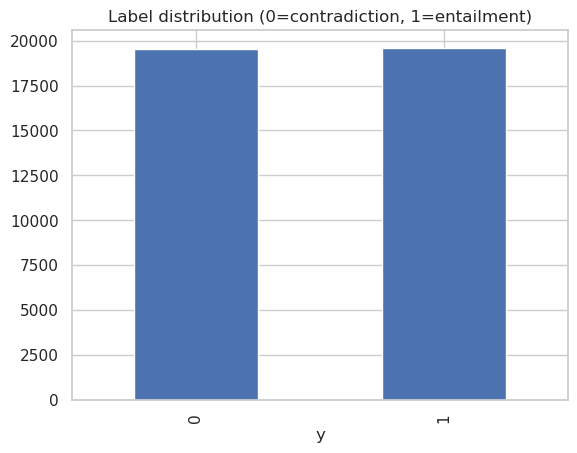

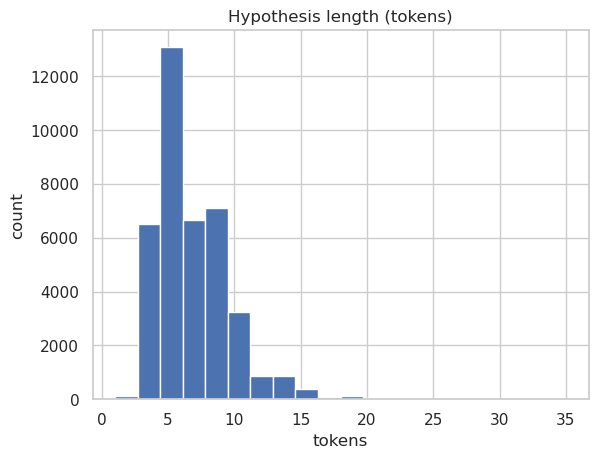

,path,hypo,y
38567,A2_Images/448590900.jpg,the dog is playing in the snow,0
6231,A2_Images/195962790.jpg,A lady is sitting outside.,1
34954,A2_Images/3735084476.jpg,A old man is working the soil of a farm.,1


In [9]:
# === 2. EDA ===
print("Class counts:\n", df["y"].value_counts())
df["len_hypo"] = df["hypo"].str.split().apply(len)

plt.figure(); df["y"].value_counts().sort_index().plot(kind="bar")
plt.title("Label distribution (0=contradiction, 1=entailment)"); plt.show()

plt.figure(); plt.hist(df["len_hypo"], bins=20)
plt.title("Hypothesis length (tokens)"); plt.xlabel("tokens"); plt.ylabel("count"); plt.show()

# Show a few samples
df.sample(3, random_state=SEED)[["path","hypo","y"]]


## Text length distribution

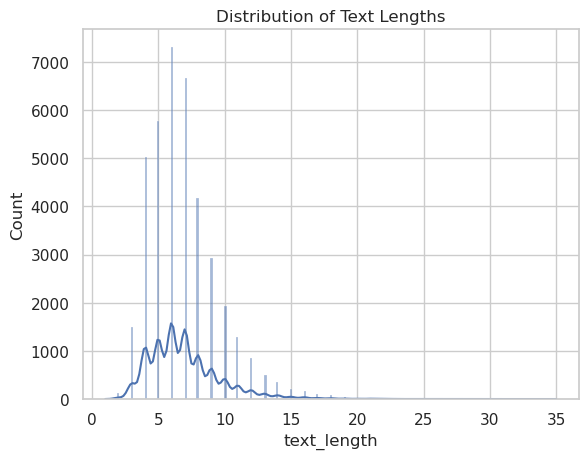

count    39129.000000
mean         6.935291
std          2.732952
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         35.000000
Name: text_length, dtype: float64


In [10]:
temp_df = pd.DataFrame()

# Calculate the length of text for each sample in words
temp_df['text_length'] = df['hypo'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths with a kernel density estimate
sns.histplot(temp_df['text_length'], kde=True)
plt.title("Distribution of Text Lengths")
plt.show()

# Display descriptive statistics for text lengths to check for outliers
print(temp_df['text_length'].describe())

          len_words     len_chars
count  39129.000000  39129.000000
mean       6.935291     34.865522
std        2.732952     14.044893
min        1.000000      1.000000
25%        5.000000     25.000000
50%        6.000000     32.000000
75%        8.000000     41.000000
max       35.000000    204.000000


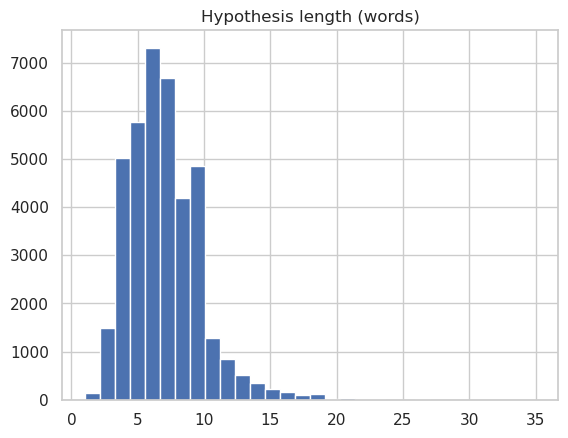

Negation prevalence: 0.02680876076567252


In [11]:
neg_words = {"no","not","none","never","without","nothing","nobody","isn't","aren't","wasn't","weren't","don't","doesn't","didn't","can't","cannot","won't","wouldn't","shouldn't"}

df["len_words"] = df["hypo"].str.split().str.len()
df["len_chars"] = df["hypo"].str.len()
df["has_neg"]   = df["hypo"].str.lower().apply(lambda s: any(w in s.split() for w in neg_words))

print(df[["len_words","len_chars","has_neg"]].describe())
plt.figure(); plt.hist(df["len_words"], bins=30); plt.title("Hypothesis length (words)"); plt.show()
print("Negation prevalence:", df["has_neg"].mean())


Corrupt images in sample: 0


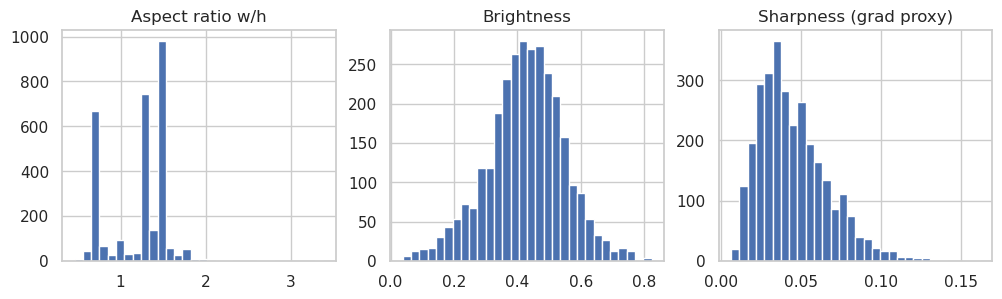

In [12]:
from PIL import Image
import numpy as np, os, pandas as pd, matplotlib.pyplot as plt

def image_meta(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
            gray = im.convert("L")
            arr  = np.asarray(gray, dtype=np.float32) / 255.0
            bright   = float(arr.mean())             # 0..1
            contrast = float(arr.std())              # 0..~0.3
            # simple sharpness proxy: mean gradient magnitude (no OpenCV needed)
            gx = np.abs(np.diff(arr, axis=1)).mean()
            gy = np.abs(np.diff(arr, axis=0)).mean()
            sharp = float((gx + gy) / 2)
            size_bytes = os.path.getsize(path)
            ext = os.path.splitext(path)[1].lower()
            return w, h, (w/h), bright, contrast, sharp, size_bytes, ext, 1
    except Exception:
        return None, None, None, None, None, None, None, None, 0  # corrupt

# sample or full set
sample_paths = df["path"].sample(min(3000, len(df)), random_state=42).tolist()
meta = [image_meta(p) for p in sample_paths]
meta_df = pd.DataFrame(meta, columns=["w","h","aspect","brightness","contrast","sharp","bytes","ext","ok"])

print("Corrupt images in sample:", (meta_df["ok"]==0).sum())
fig, axes = plt.subplots(1,3, figsize=(12,3))
axes[0].hist(meta_df["aspect"].dropna(), bins=30); axes[0].set_title("Aspect ratio w/h")
axes[1].hist(meta_df["brightness"].dropna(), bins=30); axes[1].set_title("Brightness")
axes[2].hist(meta_df["sharp"].dropna(), bins=30); axes[2].set_title("Sharpness (grad proxy)")
plt.show()


In [13]:
# --- Duplicate audit tailored for VE ---

# 1) Images reused across different hypotheses (expected)
reuse_count = df["image_id"].duplicated().sum()
print(f"Images reused across rows (expected in VE): {reuse_count}")

# 2) Exact duplicates (same image_id + hypothesis + label)
dup_exact = df.duplicated(subset=["image_id","hypo","y"]).sum()
print("Exact duplicate samples:", dup_exact)

# 3) Conflicts: same (image_id, hypo) with different labels
conflicts = (
    df.groupby(["image_id","hypo"])["y"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)
print("Label conflicts (same image+hypo with different labels):", len(conflicts))

# --- Cleaning policy ---

# A) Drop exact duplicates safely
df = df.drop_duplicates(subset=["image_id","hypo","y"]).copy()

# B) Resolve label conflicts by majority vote per (image_id, hypo).
#    If there's a tie, drop those tied pairs to be safe.
if len(conflicts):
    counts = (
        df.groupby(["image_id","hypo","y"]).size()
          .reset_index(name="cnt")
    )
    # pick label with max count for each (image_id,hypo)
    winners = counts.loc[counts.groupby(["image_id","hypo"])["cnt"].idxmax()]
    # detect ties (two labels with equal max cnt)
    tie_mask = (
        counts.merge(
            winners[["image_id","hypo","cnt"]],
            on=["image_id","hypo","cnt"],
            how="right"
        ).groupby(["image_id","hypo"]).size().gt(1)
    )
    ties = tie_mask[tie_mask].index if hasattr(tie_mask, "index") else []

    # keep only winning label rows; drop ties entirely
    keep_pairs = set(zip(winners["image_id"], winners["hypo"], winners["y"]))
    df = df[[ (iid, h, y) in keep_pairs for iid, h, y in zip(df.image_id, df.hypo, df.y) ]].copy()

    if len(ties):
        print(f"Dropped {len(ties)} tied (image,hypo) pairs due to label ties.")

# --- Re-run minimal assertions ---

assert (df["path"].apply(os.path.exists)).all(), "Some image paths are missing."
assert df["y"].isin([0,1]).all(), "Found invalid labels."
assert df["hypo"].astype(str).str.strip().ne("").all(), "Found empty hypotheses."
# No assertion on duplicate image_id by itself — that is normal in VE.

print("Audit OK: no empty/invalid labels, no empty hypotheses, paths exist, "
      "exact duplicates removed, conflicts resolved.")


Images reused across rows (expected in VE): 19556
Exact duplicate samples: 7
Label conflicts (same image+hypo with different labels): 0
Audit OK: no empty/invalid labels, no empty hypotheses, paths exist, exact duplicates removed, conflicts resolved.


In [14]:
# ============================================
# 4) Split (stratified) + post-split check
# ============================================
train_df, test_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df["y"])
train_df, val_df  = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df["y"])

# ensure len_words exists (safety)
for frame in (train_df, val_df, test_df):
    if "len_words" not in frame.columns:
        frame["len_words"] = frame["hypo"].str.split().str.len()

for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    mu = float(d["len_words"].mean())
    sigma = float(d["len_words"].std())
    print(
        name,
        "size=", len(d),
        "label dist=", d["y"].value_counts(normalize=True).round(3).to_dict(),
        "len_words μ±σ=", (round(mu, 2), round(sigma, 2))
    )



train size= 28265 label dist= {1: 0.501, 0: 0.499} len_words μ±σ= (6.93, 2.73)
val size= 4988 label dist= {1: 0.501, 0: 0.499} len_words μ±σ= (6.97, 2.71)
test size= 5869 label dist= {1: 0.501, 0: 0.499} len_words μ±σ= (6.96, 2.77)


In [15]:
# ============================================
# 5) Text vectorizer (fit on TRAIN only)
# ============================================
text_vec = layers.TextVectorization(
    max_tokens=MAX_VOCAB,
    output_mode="int",
    output_sequence_length=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)
text_vec.adapt(tf.data.Dataset.from_tensor_slices(train_df["hypo"].values).batch(256))

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/tokenizer_vocab.txt","w",encoding="utf-8") as f:
    f.write("\n".join(text_vec.get_vocabulary()))


I0000 00:00:1759293060.334699   12350 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5
2025-10-01 04:31:01.138587: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# ============================================
# 6) Image loader, augmentation, and tf.data datasets
# ============================================
def decode_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape((*IMG_SIZE, 3))
    return img

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="img_aug")

def make_ds(frame: pd.DataFrame, training: bool):
    ds = tf.data.Dataset.from_tensor_slices(
        (frame["path"].values, frame["hypo"].values, frame["y"].values)
    )
    if training:
        ds = ds.shuffle(len(frame), seed=SEED)

    def _map(p, h, y):
        img = decode_image(p)
        if training:
            img = augment(img)
        # tok = text_vec(h)
        # return (img, tok), tf.cast(y, tf.float32)
        return {"image": img, "hypothesis": h}, tf.cast(y, tf.float32)

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(BATCH)\
             .prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)
test_ds  = make_ds(test_df,  training=False)


In [ ]:
# # ============================================
# # 7) Baseline model (EffNetB0 + BiLSTM → concat)
# # ============================================
# def build_baseline(vocab_size: int, img_shape=(*IMG_SIZE,3), rnn_units=128):
#     # Image backbone (feature extractor)
#     base = keras.applications.EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
#     base.trainable = False

#     img_in = layers.Input(shape=img_shape, name="image")
#     x = base(img_in, training=False)
#     x = layers.GlobalAveragePooling2D()(x)

#     # Text branch (your designed part)
#     txt_in = layers.Input(shape=(MAX_TOKENS,), dtype="int32", name="tokens")
#     t = layers.Embedding(vocab_size, 128, mask_zero=True)(txt_in)
#     t = layers.Bidirectional(layers.LSTM(rnn_units))(t)
#     t = layers.Dropout(0.3)(t)

#     # Fusion (concat) + head
#     z = layers.Concatenate()([x, t])
#     z = layers.Dense(256, activation="relu")(z)
#     z = layers.BatchNormalization()(z)
#     z = layers.Dropout(0.4)(z)
#     out = layers.Dense(1, activation="sigmoid")(z)

#     return keras.Model([img_in, txt_in], out, name="baseline_concat")

# vocab_size = len(text_vec.get_vocabulary())
# model = build_baseline(vocab_size=vocab_size)
# model.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss="binary_crossentropy",
#               metrics=[keras.metrics.BinaryAccuracy(name="acc")])
# model.summary()


In [17]:
import tensorflow as tf
import keras, keras_hub
from keras import layers

IMG_SIZE = (224, 224)
SEQ_LEN  = 32
PRESET   = "bert_small_en_uncased"  # pick a preset you have

# image loader / augment (pure keras layers)
def decode_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape((*IMG_SIZE, 3))
    return img

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="img_aug")

# --- Instantiate the KerasHub preprocessor ONCE (outside the model) ---
try:
    preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
except AttributeError:
    # fallback for versions exposing a generic classifier preprocessor
    preproc = keras_hub.models.TextClassifierPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)

# Make sure you have these in scope:
# preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
# or the TextClassifierPreprocessor fallback, as you used before.

def _bert_pack(hypo_str):
    """
    Robustly run KerasHub BERT preprocessor in tf.data:
    - Expand dims to [1] so outputs are [1, SEQ_LEN]
    - Then squeeze back to [SEQ_LEN]
    - Normalize key names across versions
    """
    h = tf.expand_dims(hypo_str, 0)         # [1]
    out = preproc(h)                         # dict with [1, SEQ_LEN] tensors

    # key normalization (some versions use 'segment_ids', others 'token_type_ids')
    seg_key = "segment_ids"
    if seg_key not in out:
        seg_key = "token_type_ids" if "token_type_ids" in out else None

    token_ids    = tf.squeeze(out["token_ids"],    axis=0)   # (SEQ_LEN,)
    padding_mask = tf.squeeze(out["padding_mask"], axis=0)   # (SEQ_LEN,)
    if seg_key is not None:
        segment_ids = tf.squeeze(out[seg_key], axis=0)       # (SEQ_LEN,)
    else:
        segment_ids = tf.zeros_like(token_ids)               # (SEQ_LEN,)

    # set static shapes for tf.function tracing
    token_ids.set_shape((SEQ_LEN,))
    segment_ids.set_shape((SEQ_LEN,))
    padding_mask.set_shape((SEQ_LEN,))

    # (types are usually int32/int32/bool already; enforce if needed)
    token_ids    = tf.cast(token_ids, tf.int32)
    segment_ids  = tf.cast(segment_ids, tf.int32)
    padding_mask = tf.cast(padding_mask, tf.bool)

    return token_ids, segment_ids, padding_mask


def make_ds_bert(frame, training: bool, batch=32):
    ds = tf.data.Dataset.from_tensor_slices(
        (frame["path"].values, frame["hypo"].values, frame["y"].values)
    )
    if training:
        ds = ds.shuffle(len(frame), seed=42)

    def _map(p, h, y):
        img = decode_image(p)
        if training:
            img = augment(img)
        tok, seg, mask = _bert_pack(h)
        features = {
            "image": img,
            "token_ids": tok,
            "segment_ids": seg,
            "padding_mask": mask,
        }
        return features, tf.cast(y, tf.float32)

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(batch)\
             .prefetch(tf.data.AUTOTUNE)


## Stage-1 Keeping both backbones frozen
In the stage 1 the model is trained with frozen and then in stage 2 we are unfreezing some layer

In [18]:
def build_concat_keras_hub_bert(img_shape=(224,224,3), preset=PRESET, seq_len=SEQ_LEN):
    # Image branch (frozen EfficientNet)
    img_in   = layers.Input(shape=img_shape, name="image")
    img_base = keras.applications.EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
    img_base.trainable = False
    xi = img_base(img_in, training=False)
    xi = layers.GlobalAveragePooling2D(name="img_gap")(xi)

    # BERT numeric inputs (from dataset)
    token_ids_in    = layers.Input(shape=(seq_len,), dtype="int32",  name="token_ids")
    segment_ids_in  = layers.Input(shape=(seq_len,), dtype="int32",  name="segment_ids")
    padding_mask_in = layers.Input(shape=(seq_len,), dtype="bool",   name="padding_mask")

    bert_in = {
        "token_ids": token_ids_in,
        "segment_ids": segment_ids_in,
        "padding_mask": padding_mask_in,
    }

    bert = keras_hub.models.BertBackbone.from_preset(preset)
    bert.trainable = False  # start frozen
    bert_out = bert(bert_in)                       # dict
    t_pooled = bert_out["pooled_output"]          # [CLS]

    # Concat fusion + head
    z = layers.Concatenate()([xi, t_pooled])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.4)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    return keras.Model(
        inputs={"image": img_in, "token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in},
        outputs=out,
        name="baseline_concat_keras_hub_bert_numeric",
    )

model = build_concat_keras_hub_bert()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])
model.summary()


Model: "baseline_concat_keras_hub_bert_numeric"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_gap             │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 32, 512)]  │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ img_gap[0][0],    │
│ (Concatenate)       │                   │            │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    459,008 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,273,508 (126.93 MB)

 Trainable params: 459,777 (1.75 MB)

 Non-trainable params: 32,813,731 (125.17 MB)

Epoch 1/2


2025-10-01 04:31:41.785020: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1759293112.737710   13598 service.cc:152] XLA service 0x557a9bb41530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759293112.737735   13598 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-01 04:31:53.212524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759293115.321979   13598 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/884 ━━━━━━━━━━━━━━━━━━━━ 7:05:09 29s/step - acc: 0.5625 - loss: 1.0124

I0000 00:00:1759293130.157477   13598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


884/884 ━━━━━━━━━━━━━━━━━━━━ 591s 637ms/step - acc: 0.6008 - loss: 0.7204 - val_acc: 0.6688 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 2/2
884/884 ━━━━━━━━━━━━━━━━━━━━ 285s 322ms/step - acc: 0.6511 - loss: 0.6250 - val_acc: 0.6718 - val_loss: 0.6023 - learning_rate: 0.0010


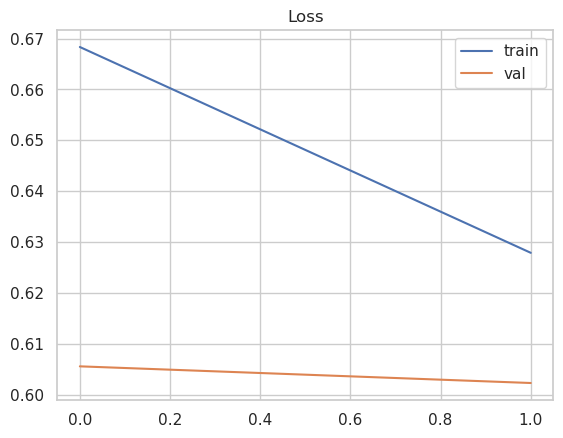

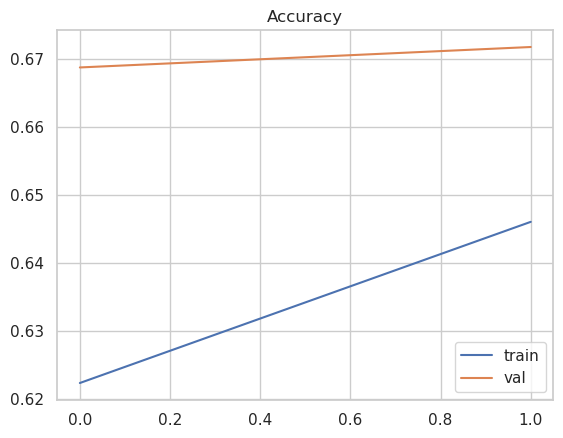

In [19]:
train_ds = make_ds_bert(train_df, training=True,  batch=32)
val_ds   = make_ds_bert(val_df,   training=False, batch=32)

cbs = [
    keras.callbacks.ModelCheckpoint("artifacts/best_bert_concat.keras", monitor="val_acc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2),
]
hist = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=cbs, verbose=1)

# Keep curves in notebook (rubric requires)
plt.figure(); plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"])
plt.title("Loss"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(hist.history["acc"]); plt.plot(hist.history["val_acc"])
plt.title("Accuracy"); plt.legend(["train","val"]); plt.show()


## Stage 2 , unfreezing some of the layer

In [24]:
# ------- Utilities to unfreeze selectively -------
import keras
from keras import layers

def unfreeze_efficientnet_top(model, pct=0.3, freeze_bn=True):
    """Unfreeze top pct of EfficientNet layers in-place."""
    eff = next((l for l in model.layers if isinstance(l, keras.Model) and "efficientnet" in l.name.lower()), None)
    if eff is None:
        print("EfficientNet backbone not found."); return
    n = len(eff.layers)
    cut = int(n * (1 - pct))
    for i, lyr in enumerate(eff.layers):
        lyr.trainable = (i >= cut)
        if freeze_bn and isinstance(lyr, layers.BatchNormalization):
            lyr.trainable = False
    print(f"EfficientNet: set trainable on top {pct*100:.0f}% (~{n-cut}/{n} layers). BN frozen={freeze_bn}")


def unfreeze_bert_last_n_smart(model, n=2):
    """Unfreeze the last n transformer blocks of a KerasHub BertBackbone inside `model`.
       Tries multiple attribute layouts; falls back to unfreezing the last few trainable sublayers.
    """
    # find the BertBackbone submodel
    bert = next((l for l in model.layers if isinstance(l, keras.Model) and "bert" in l.name.lower()), None)
    if bert is None:
        print("BERT backbone not found."); 
        return False

    # 1) KerasHub sometimes exposes `transformer_layers`
    if hasattr(bert, "transformer_layers") and bert.transformer_layers:
        blocks = list(bert.transformer_layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} transformer_layers")
        return True

    # 2) Older/newer shapes: encoder.layers
    enc = getattr(bert, "encoder", None)
    if enc is not None and hasattr(enc, "layers") and enc.layers:
        blocks = list(enc.layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} encoder layers")
        return True

    # 3) Name-based grouping (catch-all)
    #    Find top-level blocks whose names look like encoder/transformer blocks.
    block_candidates = []
    for l in bert.layers:
        if re.search(r"(transformer|encoder).*block", l.name):
            block_candidates.append(l)
    if block_candidates:
        for i, blk in enumerate(block_candidates):
            blk.trainable = (i >= len(block_candidates) - n)
        print(f"BERT: set trainable on last {n}/{len(block_candidates)} name-detected blocks")
        return True

    # 4) Final fallback: unfreeze the last K trainable sublayers (coarse but effective)
    trainable_sublayers = [l for l in bert.submodules if hasattr(l, "trainable_weights") and l.trainable_weights]
    if trainable_sublayers:
        K = max(10, 4*n)  # heuristic
        for l in trainable_sublayers[:-K]:
            l.trainable = False
        for l in trainable_sublayers[-K:]:
            l.trainable = True
        print(f"BERT: block list not found; unfroze last {K} trainable sublayers (fallback).")
        return True

    print("BERT encoder blocks still not accessible; left BERT frozen.")
    return False

def recompile_for_finetune(model, lr=1e-5):
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="binary_crossentropy",
                  metrics=[keras.metrics.BinaryAccuracy(name="acc")])


In [25]:
# # ------- Stage 2: fine-tune (small LR) -------
# unfreeze_efficientnet_top(model, pct=0.35, freeze_bn=True)  # top ~35% conv blocks
# unfreeze_bert_last_n(model, n=2)                            # last 2 transformer blocks
# recompile_for_finetune(model, lr=1e-5)                      # smaller LR for FT

# hist2 = model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=cbs, verbose=1)


# Unfreeze a slice of EfficientNet (you already did this)
unfreeze_efficientnet_top(model, pct=0.35, freeze_bn=True)

# Try to unfreeze last 2 BERT blocks, robustly:
ok = unfreeze_bert_last_n_smart(model, n=2)

# Recompile with a small LR and train a few more epochs
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])

hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=cbs, verbose=1)



EfficientNet: set trainable on top 35% (~84/238 layers). BN frozen=True
BERT: set trainable on last 2/4 transformer_layers
Epoch 1/3
884/884 ━━━━━━━━━━━━━━━━━━━━ 380s 386ms/step - acc: 0.6800 - loss: 0.5925 - val_acc: 0.7285 - val_loss: 0.5292 - learning_rate: 1.0000e-05
Epoch 2/3
884/884 ━━━━━━━━━━━━━━━━━━━━ 310s 350ms/step - acc: 0.7147 - loss: 0.5427 - val_acc: 0.7438 - val_loss: 0.5097 - learning_rate: 1.0000e-05
Epoch 3/3
884/884 ━━━━━━━━━━━━━━━━━━━━ 310s 350ms/step - acc: 0.7365 - loss: 0.5203 - val_acc: 0.7484 - val_loss: 0.4980 - learning_rate: 1.0000e-05


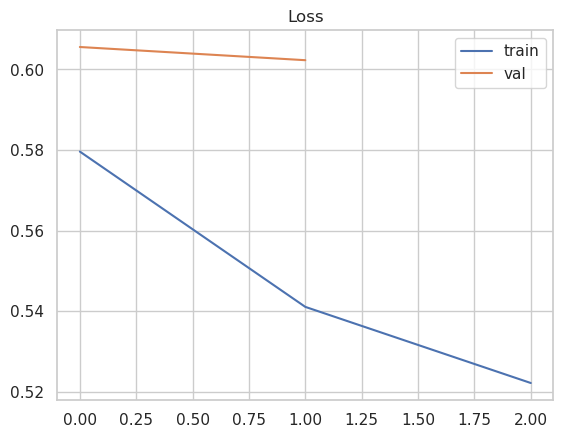

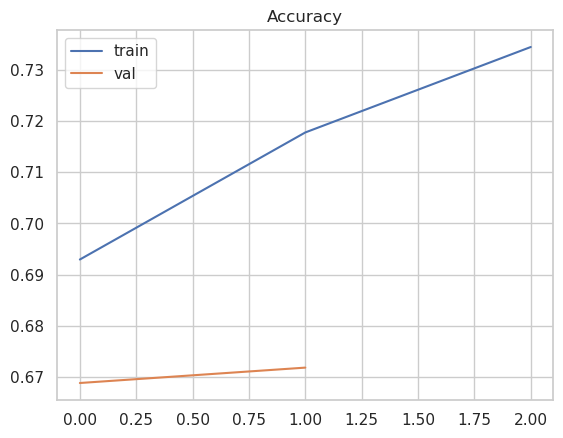

In [26]:
# Keep curves in notebook (rubric requires)
plt.figure(); plt.plot(hist_ft.history["loss"]); plt.plot(hist.history["val_loss"])
plt.title("Loss"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(hist_ft.history["acc"]); plt.plot(hist.history["val_acc"])
plt.title("Accuracy"); plt.legend(["train","val"]); plt.show()